### Imports, plot settings, and seeds

In [1]:
# Imports from here: https://blackjax-devs.github.io/sampling-book/algorithms/mclmc.html#how-to-run-mclmc-in-blackjax

import matplotlib.pyplot as plt

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 19

import jax
import blackjax
import numpy as np
import jax.numpy as jnp
from datetime import date
import numpyro
import numpyro.distributions as dist

from numpyro.infer.util import initialize_model

rng_key = jax.random.key(548)


# Imports for Adjusted MCLMC (MAMS)
from blackjax.mcmc.adjusted_mclmc_dynamic import rescale
from blackjax.util import run_inference_algorithm


# Imports for NUTS
import jax.scipy.stats as stats


# JAX guide: https://docs.jax.dev/en/latest/notebooks/thinking_in_jax.html
# Blackjax guide: https://blackjax-devs.github.io/sampling-book/




# Bayes Opt for JAX
# Boax guide: https://boax.readthedocs.io/en/latest/index.html
from boax.experiments import optimization


In [28]:
print(f"The jax key is {rng_key}")

The jax key is Array((), dtype=key<fry>) overlaying:
[  0 548]


### Make a few target densities

In [29]:
# High dimensional Gaussian

In [30]:
# Neal's funnel
def logdensity_fn(x):

    dim = len(x)
    log_prob = -0.5 * (x[0]**2 / 9.0)  # Prior on x[0]
    log_prob += -0.5 * (dim - 1) * x[0]  # Jacobian adjustment
    log_prob += -0.5 * jnp.sum(x[1:]**2 * jnp.exp(-x[0]))  # Conditional on x[0]
    return log_prob

In [31]:
# Banana or Rosenbrock

### Setup NUTS, MCLMC, MAMS

In [32]:
# NUTS

# See: https://blackjax-devs.github.io/blackjax/examples/quickstart.html#nuts

loc, scale = 10, 20
observed = np.random.normal(loc, scale, size=1_000)
def logdensity_fn(loc, log_scale, observed=observed):
    """Univariate Normal"""
    scale = jnp.exp(log_scale)
    logjac = log_scale
    logpdf = stats.norm.logpdf(observed, loc, scale)
    return logjac + jnp.sum(logpdf)


logdensity = lambda x: logdensity_fn(**x)

inv_mass_matrix = np.array([0.5, 0.01])
step_size = 1e-3


nuts = blackjax.nuts(logdensity, step_size, inv_mass_matrix)

initial_position = {"loc": 1.0, "log_scale": 1.0}
initial_state = nuts.init(initial_position)
initial_state


HMCState(position={'loc': 1.0, 'log_scale': 1.0}, logdensity=Array(-34149.637, dtype=float32), logdensity_grad={'loc': Array(1156.8735, dtype=float32, weak_type=True), 'log_scale': Array(63464.395, dtype=float32, weak_type=True)})

In [33]:
# MCLMC

# See: https://blackjax-devs.github.io/sampling-book/algorithms/mclmc.html#how-to-run-mclmc-in-blackjax


def run_mclmc(logdensity_fn, num_steps, initial_position, key, transform, desired_energy_variance= 5e-4):
    init_key, tune_key, run_key = jax.random.split(key, 3)

    # create an initial state for the sampler
    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=init_key
    )

    # build the kernel
    kernel = lambda inverse_mass_matrix : blackjax.mcmc.mclmc.build_kernel(
        logdensity_fn=logdensity_fn,
        integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
        inverse_mass_matrix=inverse_mass_matrix,
    )

    # find values for L and step_size
    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
        _
    ) = blackjax.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
        diagonal_preconditioning=False,
        desired_energy_var=desired_energy_variance
    )

    # use the quick wrapper to build a new kernel with the tuned parameters
    sampling_alg = blackjax.mclmc(
        logdensity_fn,
        L=blackjax_mclmc_sampler_params.L,
        step_size=blackjax_mclmc_sampler_params.step_size,
    )

    # run the sampler
    _, samples = blackjax.util.run_inference_algorithm(
        rng_key=run_key,
        initial_state=blackjax_state_after_tuning,
        inference_algorithm=sampling_alg,
        num_steps=num_steps,
        transform=transform,
        progress_bar=True,
    )

    return samples, blackjax_state_after_tuning, blackjax_mclmc_sampler_params, run_key

In [ ]:
# MAMS

# See: https://blackjax-devs.github.io/sampling-book/algorithms/mclmc.html#adjusted-mclmc

# For adaptation see: https://blackjax-devs.github.io/blackjax/autoapi/blackjax/adaptation/adjusted_mclmc_adaptation/index.html
# adjusted_mclmc_find_L_and_step_size is used here

def run_adjusted_mclmc_dynamic(
    logdensity_fn,
    num_steps,
    initial_position,
    key,
    transform=lambda state, _ : state.position,
    diagonal_preconditioning=True,
    random_trajectory_length=True,
    L_proposal_factor=jnp.inf
):

    init_key, tune_key, run_key = jax.random.split(key, 3)

    initial_state = blackjax.mcmc.adjusted_mclmc_dynamic.init(
        position=initial_position,
        logdensity_fn=logdensity_fn,
        random_generator_arg=init_key,
    )

    if random_trajectory_length:
        integration_steps_fn = lambda avg_num_integration_steps: lambda k: jnp.ceil(
            jax.random.uniform(k) * rescale(avg_num_integration_steps))
    else:
        integration_steps_fn = lambda avg_num_integration_steps: lambda _: jnp.ceil(avg_num_integration_steps)

    kernel = lambda rng_key, state, avg_num_integration_steps, step_size, inverse_mass_matrix: blackjax.mcmc.adjusted_mclmc_dynamic.build_kernel(
        integration_steps_fn=integration_steps_fn(avg_num_integration_steps),
        inverse_mass_matrix=inverse_mass_matrix,
    )(
        rng_key=rng_key,
        state=state,
        step_size=step_size,
        logdensity_fn=logdensity_fn,
        L_proposal_factor=L_proposal_factor,
    )

    target_acc_rate = 0.9 # our recommendation

    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
        _
    ) = blackjax.adjusted_mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
        target=target_acc_rate,
        frac_tune1=0.1,
        frac_tune2=0.1,
        frac_tune3=0.1, # our recommendation
        diagonal_preconditioning=diagonal_preconditioning,
    )

    step_size = blackjax_mclmc_sampler_params.step_size
    L = blackjax_mclmc_sampler_params.L

    alg = blackjax.adjusted_mclmc_dynamic(
        logdensity_fn=logdensity_fn,
        step_size=step_size,
        integration_steps_fn=lambda key: jnp.ceil(
            jax.random.uniform(key) * rescale(L / step_size)
        ),
        inverse_mass_matrix=blackjax_mclmc_sampler_params.inverse_mass_matrix,
        L_proposal_factor=L_proposal_factor,
    )

    _, out = run_inference_algorithm(
        rng_key=run_key,
        initial_state=blackjax_state_after_tuning,
        inference_algorithm=alg,
        num_steps=num_steps,
        transform=transform,
        progress_bar=True,
    )

    return out

Make a few plots

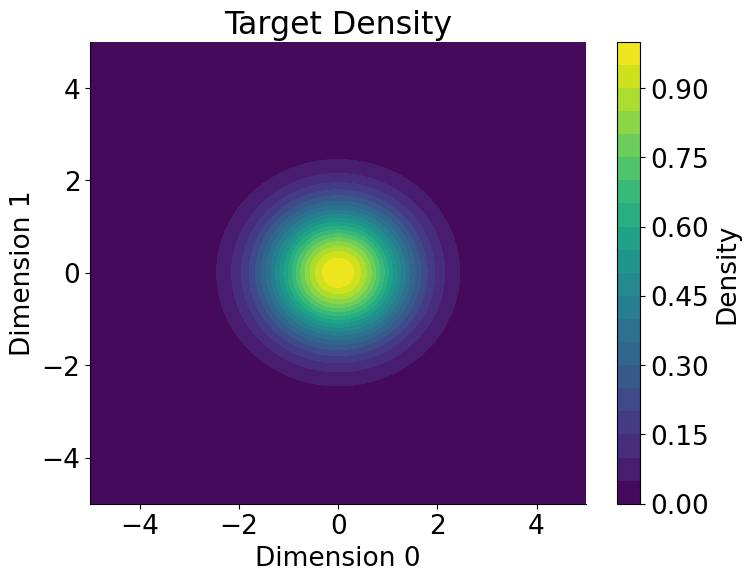

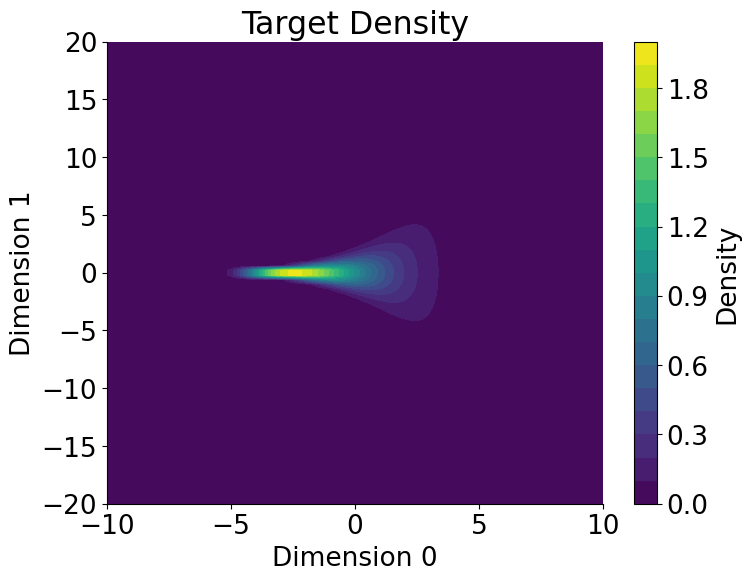

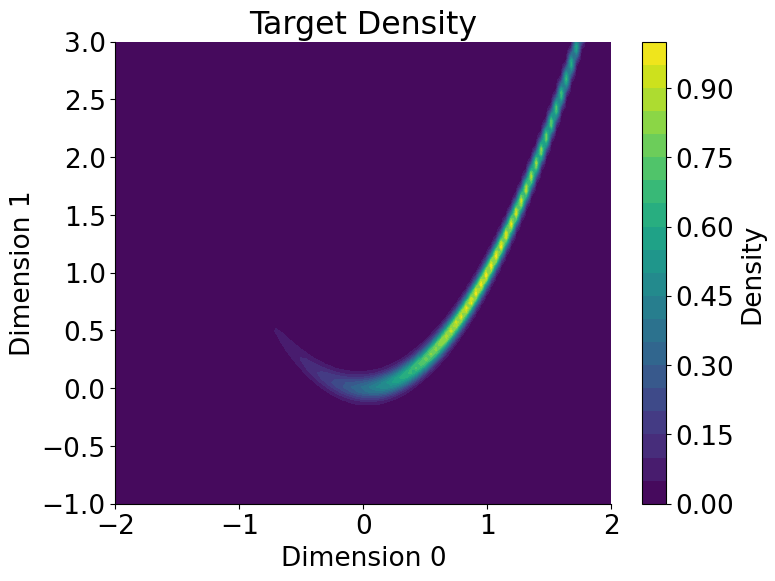

In [40]:
# Target densities
def gaussian_logdensity(x):
    return -0.5 * jnp.sum(x**2)

def rosenbrock_logdensity(x, a=1.0, b=100.0):
    return -jnp.sum(b * (x[1:] - x[:-1]**2)**2 + (a - x[:-1])**2)

def neals_funnel_logdensity(x):
    dim = len(x)
    log_prob = -0.5 * (x[0]**2 / 9.0)
    log_prob += -0.5 * (dim - 1) * x[0]
    log_prob += -0.5 * jnp.sum(x[1:]**2 * jnp.exp(-x[0]))
    return log_prob

# Plot 2D slice of target
def plot_target_2d(logdensity_fn, dim, dims_to_plot=[0,1], grid_size=100, xlim=(-5,5), ylim=(-5,5)):
    x = jnp.linspace(xlim[0], xlim[1], grid_size)
    y = jnp.linspace(ylim[0], ylim[1], grid_size)
    X, Y = jnp.meshgrid(x, y)
    
    # Evaluate density on grid
    Z = jnp.zeros_like(X)
    position = jnp.zeros(dim)
    for i in range(grid_size):
        for j in range(grid_size):
            position = position.at[dims_to_plot[0]].set(X[i,j])
            position = position.at[dims_to_plot[1]].set(Y[i,j])
            Z = Z.at[i,j].set(jnp.exp(logdensity_fn(position)))
    
    plt.figure(figsize=(8,6))
    plt.contourf(X, Y, Z, levels=20, cmap='viridis')
    plt.colorbar(label='Density')
    plt.xlabel(f'Dimension {dims_to_plot[0]}')
    plt.ylabel(f'Dimension {dims_to_plot[1]}')
    plt.title('Target Density')
    plt.show()

# Example usage
dim = 2
plot_target_2d(gaussian_logdensity, dim, dims_to_plot=[0,1])
plot_target_2d(neals_funnel_logdensity, dim, dims_to_plot=[0,1], xlim=(-10,10), ylim=(-20,20))
plot_target_2d(rosenbrock_logdensity, dim, dims_to_plot=[0,1], xlim=(-2,2), ylim=(-1,3))